# Pre-process US TMY3 Data - Single Site

Input data are available through OpenEI 
[here](https://openei.org/datasets/dataset/commercial-and-residential-hourly-load-profiles-for-all-tmy3-locations-in-the-united-states).

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

## Parameters

In [21]:
year = 2015
timestep = 60 # minutes
freq = '{}min'.format(timestep)

state = 'MA' # US state abbreviation
file_identifier = 'USA_' + state # all files start with this id

raw_data_path = Path.home() / 'Data/USA_residential_openei'
output_path = Path('../data/US_single_site_preprocessed')

profile_types_list = ['BASE', 'LOW', 'HIGH']
n_profiles = len(profile_types_list)

index = pd.DatetimeIndex(start=pd.datetime(year,1,1), 
                         end=pd.datetime(year+1,1,1), 
                         freq=freq)[:-1]

el_to_heat_cols = ['heating:electricity']
el_to_cool_cols = ['cooling:electricity']
gas_to_heat_cols = ['heating:gas', 'waterheater:watersystem:gas']

gas_to_heat_eff = 0.9
el_to_heat_eff = 2.5
el_to_cool_eff = 2.5

## Mark incomplete files and get column names

__Do not run unless necessary__

* Files with the wrong length are marked so that they do not cause trouble later on.
If necessary, several techniques are available to fill in the missing values.

* we get a list of column names

In [22]:
print('Checking all files in {}'.format(raw_data_path))
print('Files with wrong number of entries will be discarded.')

files_to_check = []
unique_columns = set()

for profile_type in profile_types_list:
    
    files = (raw_data_path / profile_type).glob(file_identifier + '*.csv')
    
    for file in files: # one by one, load all selected files
        
        load_df = pd.read_csv(file) # read csv file
        
        # get the columns
        unique_columns = unique_columns.union(load_df.columns.tolist())
        if load_df.columns.str.contains('\[J\]').any():
            print('Thermal file: {}/{}'.format(profile_type,file.name))
        
        # remove duplicates
        load_df.drop_duplicates(subset=['Date/Time'], inplace=True)
        
        if load_df.shape[0] < index.shape[0]:
            print('Marking {} as incomplete'.format(file.name))
            file.rename(file.parent / ('incomplete_' + file.name))
            
        elif load_df.shape[0] > index.shape[0]:
            print('File {} has too many entries.'.format(file.name))
            files_to_check.append(file)
            file.rename(file.parent / ('too_long_' + file.name))
            
print('Finished checking files.')
print()
print('Unique columns:')
print(*sorted(list(unique_columns)), sep='\n')

Checking all files in C:\Users\gbalestrieri\Data\USA_residential_openei
Files with wrong number of entries will be discarded.
Finished checking files.

Unique columns:
Appl:InteriorEquipment:Electricity [kW](Hourly)
Cooling:Electricity [kW](Hourly)
Date/Time
Electricity:Facility [kW](Hourly)
Electricity:HVAC [kW](Hourly)
Fans:Electricity [kW](Hourly)
Gas:Facility [kW](Hourly)
General:ExteriorLights:Electricity [kW](Hourly)
General:InteriorLights:Electricity [kW](Hourly)
HVACFan:Fans:Electricity [kW](Hourly)
Heating:Electricity [kW](Hourly)
Heating:Gas [kW](Hourly)
Misc:InteriorEquipment:Electricity [kW](Hourly)
Misc:InteriorEquipment:Electricity [kW](Hourly) 
Water Heater:WaterSystems:Gas [kW](Hourly) 


## Load Data

In [23]:
n_households = 45 # multiple of 3 because we have base, high and low load profiles

assert n_households % n_profiles == 0, '''n_households must be multiple of 
                                            the number of profile types'''

input_cols = (['electricity:facility'] + el_to_heat_cols 
              + el_to_cool_cols + gas_to_heat_cols)

load_df = pd.DataFrame(0, index=index, 
                       columns=['electricity', 'heating', 'cooling'])

for profile_type in profile_types_list:
    
    # find all csv files in the directory with name starting by 'USA_CA'
    # select the first n_households/n_profiles filenames
    files = list((raw_data_path / profile_type).glob('{}*.csv'.format(file_identifier))
                )[:n_households//n_profiles]
    
    for file in files: # one by one, load all selected files
        
        _load_df = pd.read_csv(file) # read csv file
        
        # remove duplicates
        _load_df.drop_duplicates(subset=['Date/Time'], inplace=True)
            
        _load_df.index = index # set datetime index
        
        # clean up column names
        _load_df.columns = _load_df.columns \
            .str.lower() \
            .str.replace(' ','') \
            .str.replace('\(hourly\)', '') \
            .str.replace('\[kw\]', '')
            
        # add missing columns (empty)
        for col in input_cols:
            if col not in _load_df.columns:
                _load_df[col] = 0
        
        # electricity demand
        load_df.electricity += (_load_df['electricity:facility'] 
                                - _load_df[el_to_heat_cols].sum(axis=1) 
                                - _load_df[el_to_cool_cols].sum(axis=1))
        
        # heating demand
        load_df.heating += (_load_df[gas_to_heat_cols].sum(axis=1) * gas_to_heat_eff 
                            + _load_df[el_to_heat_cols].sum(axis=1) * el_to_heat_eff)
        
        # add cooling demand
        load_df.cooling += _load_df[el_to_cool_cols].sum(axis=1) * el_to_cool_eff

In [24]:
electricity_df = load_df['electricity']
heating_df = load_df['heating']
cooling_df = load_df['cooling']

## Load Duration Curves

In [25]:
%matplotlib inline

from matplotlib import pyplot as plt
plt.style.use('ggplot')

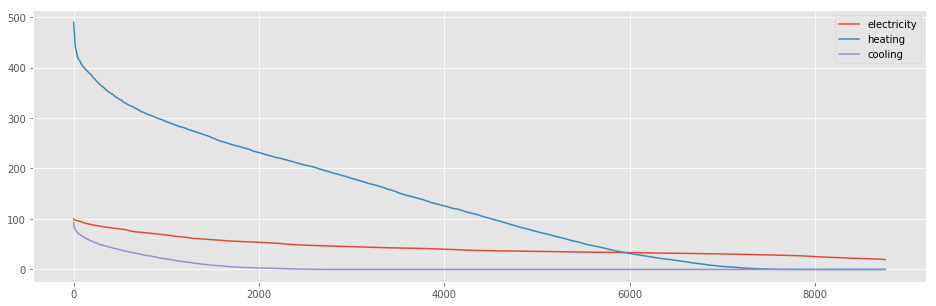

In [26]:
fig, ax = plt.subplots(figsize=(16,5))

electricity_df.sort_values(ascending=False).reset_index(drop=True).plot(
    figsize=(16,5), label='electricity', ax=ax)

heating_df.sort_values(ascending=False).reset_index(drop=True).plot(
    figsize=(16,5), label='heating', ax=ax)

cooling_df.sort_values(ascending=False).reset_index(drop=True).plot(
    figsize=(16,5), label='cooling', ax=ax)

ax.legend();

## Save Data

In [27]:
prefix = '{}_{}_'.format(state, n_households)

electricity_df.to_csv(output_path / (prefix + 'electricity.csv'), 
                      index=False, header=None, float_format='%.3f')

heating_df.to_csv(output_path / (prefix + 'heating.csv'), 
                  index=False, header=None, float_format='%.3f')

cooling_df.to_csv(output_path / (prefix + 'cooling.csv'), 
                  index=False, header=None, float_format='%.3f')